In [1055]:
from random import random, choice
from typing import Tuple
from matplotlib import pyplot as plt
import numpy as np
import gymnasium as gym

In [1056]:
num_episodes = 2000
gamma = 1
min_alpha = 0.1
min_epsilon = 0.2
fail_reward = -200

In [1057]:
class LinearSarsa():
    def __init__(self) -> None:
        self.w = np.random.rand(4, 2)
        self.iteration = 0
        self.epsilon = 1
        self.alpha = 1


    def _q_hat(
            self, 
            states: np.ndarray, 
            action: int
            ) -> float:
        return np.dot(states, self.w)[action]


    def predict(
            self, 
            states: np.ndarray,
            exploration: bool,
            ) -> int:
        self.iteration += 1

        if self.alpha > min_alpha:
            self.alpha = 1 / self.iteration
        if self.epsilon > min_epsilon:
            self.epsilon = 1 / self.iteration

        actions = [0, 1]

        # Policy iteration
        if exploration and random() < self.epsilon:
            # Exploration (random)
            return choice(actions)    
        else:
            # Greedy
            qs = [self._q_hat(states, action) for action in actions]
            return np.argmax(qs)
        

    def control(
            self, 
            states: np.ndarray, 
            action: int, 
            reward: float, 
            next_states: np.ndarray,
            terminated: bool,
            exploration: bool,
            ) -> Tuple[float, float]:
        # Policy evaluation
        if not terminated:
            next_action = self.predict(next_states, exploration)
            td_target = reward + gamma * self._q_hat(next_states, next_action)
        else:
            td_target = reward = fail_reward
            
        td_prediction = self._q_hat(states, action)
        td_error = td_target - td_prediction
        delta = self.alpha * td_error * states

        # Update parameters
        self.w[:, action] += delta
        return td_target, td_prediction

In [1058]:
env_name = "CartPole-v1"
# env = gym.make(env_name, render_mode="human")
env = gym.make(env_name)

sarsa = LinearSarsa()

try:
    rewards = np.array([])
    targets = np.array([])
    predictions = np.array([])
    
    for ep in range(num_episodes):
        states, info = env.reset()

        for time in range(500):
            action = sarsa.predict(states, True)
            next_states, reward, terminated, truncated, info = env.step(action)
            target, prediction = sarsa.control(states, action, reward, next_states, terminated, True)
            
            if terminated or truncated:
                rewards = np.append(rewards, time + 1)
                break
 
            states = next_states

        targets = np.append(targets, target)
        predictions = np.append(predictions, prediction)
finally:
    env.close()
    print("weights:", sarsa.w)

weights: [[ 146.56270334 -170.84308515]
 [  74.71494943  -50.5120909 ]
 [-120.15152612  116.27901081]
 [  19.23726932  -14.82704852]]


In [1059]:
env = gym.make(env_name, render_mode="human") # Visible
try:
    states, info = env.reset()
    action = sarsa.predict(states, False)

    for time in range(500):
        next_states, reward, terminated, truncated, info = env.step(action)
        
        env.render()
        if terminated or truncated:
            break

        next_action = sarsa.predict(next_states, False)
        sarsa.control(states, action, reward, next_states, False, False)
finally:
    env.close()
    print(time)

9


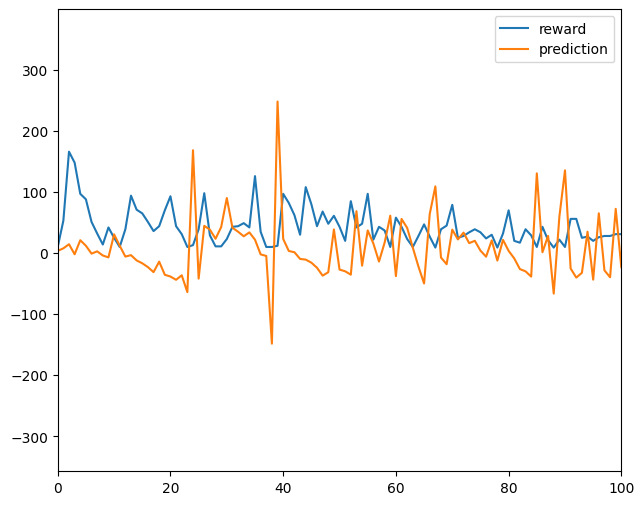

In [1061]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.xlim(0, 100)
plt.plot(rewards, label='reward')

# plt.plot(targets, label='target')
plt.plot(predictions, label='prediction')
# plt.plot(rewards - predictions, label='error')
plt.legend()
plt.show()